In [1]:
import os
import json
import numpy as np
import pandas as pd
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import nibabel as nib
import matplotlib.pyplot as plt
from dataset import CarotidDataset
from unet import UNet
from utils import DiceLoss, load_config
from torchvision import transforms
from torchvision.io import read_image

from torchvision.transforms.functional import to_pil_image

import matplotlib.pyplot as plt

In [2]:
MODEL = 'unet_3'
config_path='./config/'
config_file=f'{MODEL}.yaml'
config = load_config(config_file, config_path)
batch_size = 1
data = CarotidDataset(crop=False)
generator = torch.Generator().manual_seed(42)
_, _, test_data = torch.utils.data.random_split(data, [0.8, 0.1, 0.1], generator=generator)
dataloader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=1)

inputs, labels = next(iter(dataloader))

In [3]:
net = UNet(in_channels=config['in_channels'], 
            n_classes=config['n_classes'], 
            depth=config['depth'], 
            batch_norm=config['batch_norm'], 
            padding=config['padding'], 
            up_mode=config['up_mode'])
net.load_state_dict(torch.load(f'models/{MODEL}.pth'))
net.eval()

preds = net(inputs)
preds.shape

torch.Size([1, 1, 512, 512])

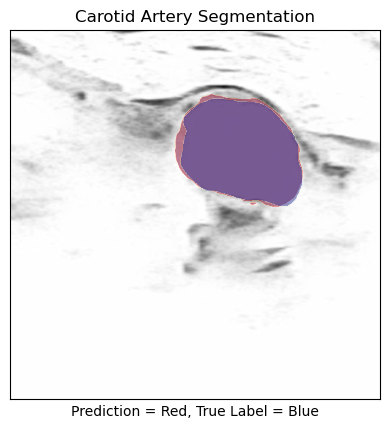

In [4]:
def plot_pred(preds, inputs, labels=None):
    pred_out = preds[0][0].detach().numpy()
    background = inputs[0][2].detach().numpy()
    plt.imshow(background, cmap='Greys', alpha=1)
    plt.imshow(pred_out, 
            cmap='YlOrRd',
            alpha=pred_out*.5)
    if labels != None:
        labels = labels > 0
        labels = labels.type(torch.int8)
        label_out = labels[0][0].numpy()
        plt.imshow(label_out, 
           cmap='RdYlBu', 
           alpha=label_out*.5)
        plt.xlabel('Prediction = Red, True Label = Blue',)
    else:
        plt.xlabel('Prediction = Red',)
    plt.title('Carotid Artery Segmentation')
    plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
    
    plt.show()

plot_pred(preds, inputs, labels)

In [5]:
inputs.shape

torch.Size([1, 3, 512, 512])

In [7]:
test_data.dataset.image_paths

['data/Common Carotid Artery Ultrasound Images/US images/202201121837530038VAS_slice_1451.png',
 'data/Common Carotid Artery Ultrasound Images/US images/202202071308300020EM VASCULAR_slice_17.png',
 'data/Common Carotid Artery Ultrasound Images/US images/202201121850550042VAS_slice_1312.png',
 'data/Common Carotid Artery Ultrasound Images/US images/202201121815070032VAS_slice_2457.png',
 'data/Common Carotid Artery Ultrasound Images/US images/202201121815070032VAS_slice_1638.png',
 'data/Common Carotid Artery Ultrasound Images/US images/202201121834300037VAS_slice_1735.png',
 'data/Common Carotid Artery Ultrasound Images/US images/202201121837530038VAS_slice_975.png',
 'data/Common Carotid Artery Ultrasound Images/US images/202201121837530038VAS_slice_785.png',
 'data/Common Carotid Artery Ultrasound Images/US images/202201121841080039VAS_slice_2319.png',
 'data/Common Carotid Artery Ultrasound Images/US images/202201121748100022VAS_slice_1965.png',
 'data/Common Carotid Artery Ultraso